Student: Nguyen Tat Dat

Id: 18020009

Paper: Aggregated Residual Transformations for Deep Neural Networks (ResNeXt)



In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, GlobalAveragePooling2D, Dense, \
    Softmax, add, Lambda, concatenate
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.backend import shape
from tensorflow import Variable


class ResNeXtModel:
    def __init__(self, input_shape, nb_classes, structure, cardinality=16, width=4, l2_weight=5e-4):
        self.width = width
        self.cardinality = cardinality
        self.structure = structure
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        self.l2_weight = l2_weight
        self.model = self.build_resnext()
        self.model.summary()
        step = Variable(0, trainable=False)
        self.model.compile(optimizer=Adam(learning_rate=1e-3), loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])

    def initial_block(self, inputs):
        x = Conv2D(64, (3, 3), padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(self.l2_weight), use_bias=False)(
            inputs)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)
        return x

    def output_block(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Dense(self.nb_classes, kernel_initializer=he_normal(), kernel_regularizer=l2(self.l2_weight))(x)
        x = Softmax()(x)
        return x

    def bottleneck_block(self, inputs, nb_filters, strides, pass_filter=False):
        x_skip = inputs
        if pass_filter:
            x_skip = Conv2D(nb_filters * 2, (1, 1), padding='same', kernel_initializer=he_normal(),
                            kernel_regularizer=l2(self.l2_weight), strides=(strides, strides), use_bias=False)(x_skip)
            x_skip = BatchNormalization()(x_skip)
        x = Conv2D(nb_filters, (1, 1), padding='same', kernel_initializer=he_normal(),
                   kernel_regularizer=l2(self.l2_weight), use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)

        x = self.grouped_block(x, int(nb_filters / self.cardinality), strides)

        x = Conv2D(nb_filters * 2, (1, 1), padding='same', kernel_initializer=he_normal(),
                   kernel_regularizer=l2(self.l2_weight), use_bias=False)(x)
        x = BatchNormalization()(x)

        x = add([x_skip, x])

        x = Activation(relu)(x)

        return x

    def build_resnext(self):
        inputs = Input(self.input_shape)
        x = self.initial_block(inputs)

        nb_filters = self.cardinality * self.width
        for stage, nb_block in enumerate(self.structure):
            for block_id in range(nb_block):
                if block_id == 0:
                    if stage > 0:
                        x = self.bottleneck_block(x, nb_filters, 2, pass_filter=True)
                    else:
                        x = self.bottleneck_block(x, nb_filters, 1, pass_filter=True)
                else:
                    x = self.bottleneck_block(x, nb_filters, 1)

            nb_filters *= 2

        x = self.output_block(x)
        model = Model(inputs=inputs, outputs=x)
        return model

    def fit(self, x, y, x_test, y_test, batch_size, epochs):
        self.model.fit(x=x, y=y, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, verbose=2)

    def grouped_block(self, inputs, group_size, strides):
        group_list = []

        for i in range(self.cardinality):
            x = Lambda(lambda _inputs: _inputs[:, :, :, i * group_size:(i + 1) * group_size])(inputs)
            x = Conv2D(group_size, (3, 3), padding='same', kernel_initializer=he_normal(),
                       kernel_regularizer=l2(self.l2_weight), strides=(strides, strides), use_bias=False)(x)
            group_list.append(x)

        x = concatenate(group_list)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)
        return x

    def get_model(self):
        return self.model


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

print(tf.__version__)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
input_shape = x_train.shape[1:]

generator = ImageDataGenerator(rotation_range=15,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               horizontal_flip=True)

generator.fit(x_train)
batch_size = 250





2.2.0-rc3


In [0]:
lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), cooldown=0, patience=1, min_lr=1e-6)

callbacks = [lr_reducer]
model = ResNeXtModel(input_shape=input_shape, nb_classes=10, structure=[3, 3, 3], cardinality=16, width=4).get_model()
history = model.fit(generator.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) // batch_size, epochs=100, callbacks=callbacks, validation_data=(x_test, y_test), validation_steps=x_test.shape[0] // batch_size, verbose=2)

Accuracy score:  90.71000000000001


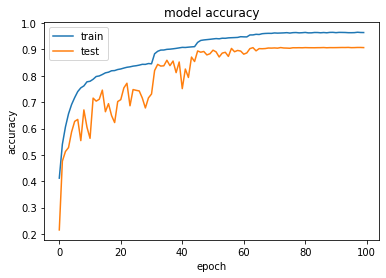

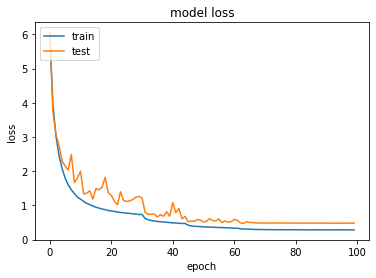

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
y_pred = np.argmax(model.predict(x_test), axis=1)
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:

print('Accuracy score: ', accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))

Accuracy score:  90.71000000000001
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1000
           1       0.93      0.97      0.95      1000
           2       0.87      0.89      0.88      1000
           3       0.86      0.79      0.82      1000
           4       0.89      0.91      0.90      1000
           5       0.93      0.80      0.86      1000
           6       0.86      0.96      0.91      1000
           7       0.95      0.94      0.94      1000
           8       0.95      0.94      0.95      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

